In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt


cifar10 = tf.keras.datasets.cifar10
(x_train, y_train), (_, _) = cifar10.load_data()
y_train = y_train.reshape(-1)


x_train = x_train.astype("float32") / 255.0


BUFFER_SIZE = 60000
BATCH_SIZE = 128
NOISE_DIM = 100
NUM_CLASSES = 10
IMG_SHAPE = (32, 32, 3)


y_train_oh = tf.keras.utils.to_categorical(y_train, NUM_CLASSES)



170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step


In [2]:

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train_oh))
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

def label_embedding(label):
    embed = layers.Embedding(NUM_CLASSES, NOISE_DIM)(label)
    embed = layers.Dense(32*32*3)(embed)
    embed = layers.Reshape((32, 32, 3))(embed)
    return embed

def build_generator():
    noise_input = layers.Input(shape=(NOISE_DIM,))
    label_input = layers.Input(shape=(NUM_CLASSES,))

    x = layers.Concatenate()([noise_input, label_input])
    x = layers.Dense(8*8*256, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Reshape((8, 8, 256))(x)

    x = layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')(x)

    return tf.keras.Model([noise_input, label_input], x)

def build_discriminator():
    image_input = layers.Input(shape=IMG_SHAPE)
    label_input = layers.Input(shape=(NUM_CLASSES,))

    label = layers.Dense(32*32*3)(label_input)
    label = layers.Reshape((32, 32, 3))(label)

    x = layers.Concatenate()([image_input, label])
    x = layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(1)(x)

    return tf.keras.Model([image_input, label_input], x)

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    return cross_entropy(tf.ones_like(real_output), real_output) + cross_entropy(tf.zeros_like(fake_output), fake_output)

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator = build_generator()
discriminator = build_discriminator()

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


Epoch 1 completed
Epoch 2 completed
Epoch 3 completed
Enter a class name (e.g., cat, ship, dog): cat


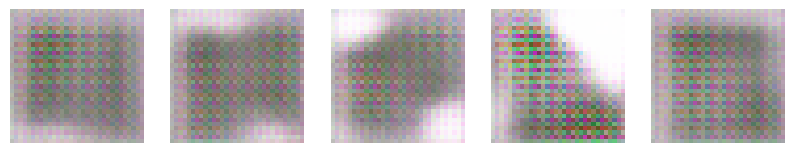

In [6]:
@tf.function
def train_step(images, labels):
    batch_size = tf.shape(labels)[0]  # Get dynamic batch size
    noise = tf.random.normal([batch_size, NOISE_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator([noise, labels], training=True)
        real_output = discriminator([images, labels], training=True)
        fake_output = discriminator([generated_images, labels], training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


# Training loop
def train(dataset, epochs):
    for epoch in range(epochs):
        for image_batch, label_batch in dataset:
            train_step(image_batch, label_batch)
        print(f"Epoch {epoch+1} completed")

# Train model (use fewer epochs if needed for quick test)
train(train_dataset, epochs=3)

# Class label mapping
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
class_dict = {name: i for i, name in enumerate(class_names)}

# Generate images from class name
def generate_images_for_class(class_name, num_images=5):
    if class_name not in class_dict:
        print("Invalid class name!")
        return
    class_index = class_dict[class_name]
    label = tf.one_hot([class_index] * num_images, NUM_CLASSES)
    noise = tf.random.normal([num_images, NOISE_DIM])
    generated_images = generator([noise, label], training=False)
    generated_images = (generated_images + 1) / 2.0

    plt.figure(figsize=(num_images * 2, 2))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(generated_images[i])
        plt.axis('off')
    plt.show()

# Get user input
user_input = input("Enter a class name (e.g., cat, ship, dog): ").strip().lower()
generate_images_for_class(user_input, num_images=5)